# Phylogenetic alpha diversity analysis

This notebook demonstrates alpha diversity analysis of the classical "[Moving Pictures](https://docs.qiime2.org/2022.8/tutorials/moving-pictures/)" dataset using Python. Please compare the results of this workflow and those of the official QIIME 2 tutorial.

This workflow requires basic Python data science libraries, including: numpy, scipy, pandas, matplotlib, and statsmodels.

It further requires the Python bioinformatics library: [scikit-bio](http://scikit-bio.org/), which provides implementations of multiple alpha diversity metrics ([list](http://scikit-bio.org/docs/latest/generated/skbio.diversity.alpha.html)), among other phylogenetic community ecology analysis functionalities.

## Preparation

Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This workflow includes multiple instances of subsampling, which is a stochastic process. Results are slightly different among replicates. Therefore, to ensure reproducibility of the results, it is important to specify a random seed in the beginning. `42` is a commonly used random seed.

In [36]:
rng = np.random.default_rng(42)

## Metadata

Read metadata table.

In [2]:
meta = pd.read_table('meta.tsv', index_col=0)
meta.head()

,barcode-sequence,body-site,year,month,day,subject,reported-antibiotic-usage,days-since-experiment-start
sample-id,,,,,,,,
L1S8,AGCTGACTAGTC,gut,2008,10,28,subject-1,Yes,0
L1S57,ACACACTATGGC,gut,2009,1,20,subject-1,No,84
L1S76,ACTACGTGTGGT,gut,2009,2,17,subject-1,No,112
L1S105,AGTGCGATGCGT,gut,2009,3,17,subject-1,No,140
L2S155,ACGATGCGACCA,left palm,2009,1,20,subject-1,No,84


Drop unuseful columns.

In [3]:
meta.drop('barcode-sequence', axis=1, inplace=True)

Rename columns to make them slimer.

In [4]:
meta.columns = ['site', 'year', 'month', 'day', 'subject', 'antibiotic', 'elapse']

In [5]:
meta.head()

,site,year,month,day,subject,antibiotic,elapse
sample-id,,,,,,,
L1S8,gut,2008,10,28,subject-1,Yes,0
L1S57,gut,2009,1,20,subject-1,No,84
L1S76,gut,2009,2,17,subject-1,No,112
L1S105,gut,2009,3,17,subject-1,No,140
L2S155,left palm,2009,1,20,subject-1,No,84


## Feature table

Read data table.

In [6]:
data = pd.read_table('data.tsv', index_col=0)
data.head()

,L1S105,L1S140,L1S208,L1S257,L1S281,L1S57,L1S76,L1S8,L2S155,L2S175,...,L4S63,L5S104,L5S155,L5S174,L5S203,L5S222,L5S240,L6S20,L6S68,L6S93
#FeatureID,,,,,,,,,,,,,,,,,,,,,
4b5eeb300368260019c1fbc7a3c718fc,2175,0,0,0,0,2806,3309,2595,10,10,...,0,10,0,0,0,0,0,0,0,0
fe30ff0f71a38a39cf1717ec2be3a2fc,5,0,0,0,0,0,0,0,0,0,...,160,0,0,0,0,0,374,3323,1723,1341
d29fe3c70564fc0f69f2c03e0d1e5561,0,0,0,0,0,0,0,0,353,779,...,417,216,140,107,215,148,117,215,500,465
868528ca947bc57b69ffdf83e6b73bae,0,2249,2107,1177,1722,0,0,0,0,0,...,0,0,0,0,5,0,10,0,0,9
154709e160e8cada6bfb21115acc80f5,803,1174,694,406,242,1081,930,1623,0,0,...,0,0,9,0,0,0,0,0,0,0


Get dimensions of the feature table.

In [7]:
data.shape

(770, 34)

## Rarefaction

### Sampling depth

Alpha diversity is sensitive to sampling depth (total number of organisms sampled in each site, which translates into the total number of sequencing reads per sample). In the data table, this value is the sum of cell values (feature frequencies) per column (sample).

In [8]:
sums = data.sum()

To ensure that alpha diversity values are comparable across samples, one needs to downsample all samples to a constant sampling depth.

In [9]:
sums.min()

897

Sometimes there may be poor-quality samples (e.g., depth < 100) in the dataset. One has to drop these samples. Therefore, it will be helpful to manually observe the distribution of depths to determine a proper depth that is both reasonably big and not losing too many samples.

In [10]:
sums.sort_values().head(10)

L3S242     897
L3S341     962
L3S360     969
L3S313    1103
L3S294    1225
L3S378    1249
L2S309    1419
L5S240    1792
L5S155    1800
L5S174    1953
dtype: int64

In the "Moving Pictures" tutorial, they chose 1103, which is 1) depth of the 4th smallest sample, 2) greater than 1000 (1000 is a recommended threshold for 16S rRNA data).

In [11]:
depth = sums[sums > 1000].sort_values().iloc[0]
depth

1103

Drop samples that have less than this depth.

In [12]:
data = data.loc[:, sums >= depth]
data.shape[1]

31

Drop features that have only zero values.

In [13]:
data = data.loc[data.sum(axis=1) > 0]

Also filter the metadata table.

In [14]:
meta = meta.loc[data.columns]
meta.shape[0]

31

### Subsampling

In this context, "rarefaction" is to perform random subsampling such that all samples have the same sampling depth (sum of cell values).

In [37]:
def rarefy(counts, n, rng):
    """Subsample a count table to a fixed depth per sample.
    """
    nonzero = counts[nzidx := np.where(counts != 0)[0]]
    permuted = rng.choice(nonzero.sum(), size=n, replace=False, shuffle=False)
    digits = np.digitize(permuted, np.cumsum(nonzero))
    idx, freqs = np.unique(digits, return_counts=True)
    result = np.zeros_like(counts)
    result[nzidx[idx]] = freqs
    return result

In [43]:
_ = rarefy(data.iloc[:, 0].values, 5, rng)

In [16]:
data_sub = data.apply(rarefy, args=(depth, 42))
data_sub.head()

/home/drz/Dropbox/PhyAdiv/github/phyadiv/phyadiv.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nonzero = counts[nzidx := np.where(counts != 0)[0]]


,L1S105,L1S140,L1S208,L1S257,L1S281,L1S57,L1S76,L1S8,L2S155,L2S175,...,L4S63,L5S104,L5S155,L5S174,L5S203,L5S222,L5S240,L6S20,L6S68,L6S93
#FeatureID,,,,,,,,,,,,,,,,,,,,,
4b5eeb300368260019c1fbc7a3c718fc,307,0,0,0,0,352,450,388,0,0,...,0,3,0,0,0,0,0,0,0,0
fe30ff0f71a38a39cf1717ec2be3a2fc,0,0,0,0,0,0,0,0,0,0,...,16,0,0,0,0,0,243,526,314,222
d29fe3c70564fc0f69f2c03e0d1e5561,0,0,0,0,0,0,0,0,105,209,...,42,108,89,55,116,57,65,34,80,63
868528ca947bc57b69ffdf83e6b73bae,0,346,276,209,281,0,0,0,0,0,...,0,0,0,0,4,0,3,0,0,1
154709e160e8cada6bfb21115acc80f5,93,170,86,57,42,129,135,266,0,0,...,0,0,9,0,0,0,0,0,0,0


After rarefaction, all samples have a sum of feature frequencies = sampling depth.

In [19]:
(data_sub.sum() == depth).all()

True

In [20]:
data_sub = pd.read_table('rarefied.tsv', index_col=0)
data_sub.head()

,L1S105,L1S140,L1S208,L1S257,L1S281,L1S57,L1S76,L1S8,L2S155,L2S175,...,L4S63,L5S104,L5S155,L5S174,L5S203,L5S222,L5S240,L6S20,L6S68,L6S93
4b5eeb300368260019c1fbc7a3c718fc,317,0,0,0,0,369,481,422,4,4,...,0,6,0,0,0,0,0,0,0,0
fe30ff0f71a38a39cf1717ec2be3a2fc,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,242,526,332,210
d29fe3c70564fc0f69f2c03e0d1e5561,0,0,0,0,0,0,0,0,98,196,...,51,119,85,63,104,61,79,36,87,85
868528ca947bc57b69ffdf83e6b73bae,0,359,287,186,293,0,0,0,0,0,...,0,0,0,0,3,0,5,0,0,1
154709e160e8cada6bfb21115acc80f5,116,159,94,80,30,135,131,252,0,0,...,0,0,5,0,0,0,0,0,0,0


Note: Subsampling data to a constant depth is different from scaling data according to relative abundance. Although the results are similar, the latter won't guarantee that the sum of frequencies is constant.

## Alpha diversity

### Observed features

The simplest alpha diversity metric is the observed species richness (_S<sub>obs</sub>_), which is simply the number of species sampled at each site, which translates into the number of non-zero features per sample. In QIIME 2, this metric is referred to as "**observed features**" for generalizability.

In [21]:
sobs = (data > 0).sum()
sobs.head()

L1S105    63
L1S140    65
L1S208    85
L1S257    81
L1S281    72
dtype: int64

### Alpha diversity metrics

Scikit-bio implements multiple alpha diversity metrics. Here is a complete [list](http://scikit-bio.org/docs/latest/generated/skbio.diversity.alpha.html) of them.

In [22]:
from skbio.diversity import alpha_diversity

One needs to transpose the feature table, such that rows are samples and columns are features.

In [23]:
data_sub_t = data_sub.T

In [24]:
counts, ids = data_sub_t.values, data_sub_t.index

We will calculate the "core" alpha diversity metrics as defined in QIIME 2, and append the results to the metadata table.

Observed OTUs (equivalent to **observed features**)

In [25]:
meta['sobs'] = alpha_diversity('observed_otus', counts, ids)
meta['sobs'].head()

L1S105    55
L1S140    61
L1S208    77
L1S257    72
L1S281    66
Name: sobs, dtype: int64

**Shannon diversity index** (_H_)

In [26]:
meta['shannon'] = alpha_diversity('shannon', counts, ids)
meta['shannon'].head()

L1S105    3.717544
L1S140    3.777692
L1S208    4.427004
L1S257    4.644124
L1S281    4.596024
Name: shannon, dtype: float64

**Pielou's evenness index** (_J_')

In [27]:
meta['pielou_e'] = alpha_diversity('pielou_e', counts, ids)
meta['pielou_e'].head()

L1S105    0.643022
L1S140    0.636968
L1S208    0.706423
L1S257    0.752704
L1S281    0.760378
Name: pielou_e, dtype: float64

### Phylogenetic metric

To calculate phylogenetic alpha diversity metrics, one needs to provide a phylogenetic tree of taxa (features).

In [28]:
from skbio.tree import TreeNode

In [29]:
tree = TreeNode.read('tree.nwk')
tree

<TreeNode, name: root, internal node count: 767, tips count: 770>

**Faith's phylogenetic diversity** (PD)

In [30]:
meta['faith_pd'] = alpha_diversity('faith_pd', counts, ids, otu_ids=data_sub_t.columns, tree=tree)
meta['faith_pd'].head()

L1S105    6.606258
L1S140    6.284829
L1S208    6.863905
L1S257    7.184280
L1S281    6.585137
Name: faith_pd, dtype: float64

Finally, take a look at the results.

In [31]:
meta.head()

,site,year,month,day,subject,antibiotic,elapse,sobs,shannon,pielou_e,faith_pd
L1S105,gut,2009,3,17,subject-1,No,140,55,3.717544,0.643022,6.606258
L1S140,gut,2008,10,28,subject-2,Yes,0,61,3.777692,0.636968,6.284829
L1S208,gut,2009,1,20,subject-2,No,84,77,4.427004,0.706423,6.863905
L1S257,gut,2009,3,17,subject-2,No,140,72,4.644124,0.752704,7.184280
L1S281,gut,2009,4,14,subject-2,No,168,66,4.596024,0.760378,6.585137


## Statistical tests

### Two-group comparison

Compare the numbers of observed features (_S<sub>obs</sub>_) in samples of the two subjects (1 vs 2).

In [32]:
meta['subject'].value_counts()

subject-2    16
subject-1    15
Name: subject, dtype: int64

In [33]:
grouped = meta.groupby('subject')['sobs'].apply(np.array)
grouped

subject
subject-1    [55, 59, 51, 38, 98, 90, 83, 134, 40, 46, 25, ...
subject-2    [61, 77, 72, 66, 43, 58, 50, 116, 30, 125, 111...
Name: sobs, dtype: object

Draw a boxplot to preview the data.

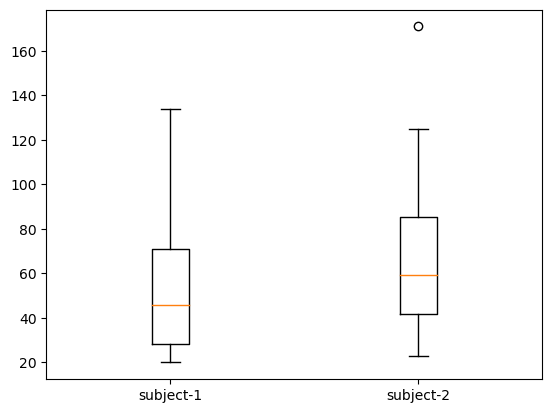

In [34]:
plt.boxplot(grouped, labels=grouped.index);

Polish the figure.

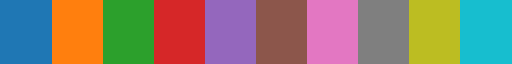

In [35]:
cmap = plt.get_cmap('tab10')
cmap

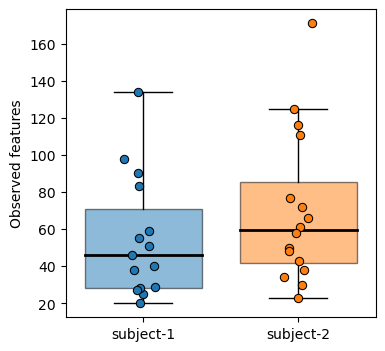

In [36]:
plt.figure(figsize=(4, 4))
for i, (group, datum) in enumerate(grouped.items()):
    bp = plt.boxplot(datum, widths=0.75, positions=(i,), labels=(group,),
                     medianprops=dict(color='k', linewidth=2),
                     showfliers=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set(facecolor=cmap(i), alpha=0.5)
    plt.scatter(np.random.normal(i, 0.05, len(datum)), datum,
                color=cmap(i), edgecolor='k', linewidth=0.75, zorder=2.5)
plt.ylabel('Observed features');

An alternative method to generate such plots is to use the `boxplot` and `stripplot` functions of the Python library [seaborn](https://seaborn.pydata.org/).

Perform statistical tests to assess whether the mean _S<sub>obs</sub>_ is significantly different between the two groups.

In microbiome research, because data are usually highly skewed, non-parametric statistical tests (i.e., those that don't assume a normal distribution of data) are favored. This includes [Mann-Whitney _U_ test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (a.k.a., Wilcoxon rank-sum test) for two groups, and [Kruskal-Wallis _H_ test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) for two or more groups.

In [37]:
from scipy.stats import mannwhitneyu, kruskal

**Mann-Whitney _U_ test**

- This is equivalent to `mannwhitneyu(grouped.iloc[0], grouped.iloc[1])`.

- Note: _U_ test doesn't work well with small sample size (_n_ < 20 per group).

In [38]:
mannwhitneyu(*grouped)

MannwhitneyuResult(statistic=89.5, pvalue=0.23563269285773247)

**Kruskal-Wallis _H_ test**

In [39]:
kruskal(*grouped)

KruskalResult(statistic=1.453808731599107, pvalue=0.22791779121839684)

Therefore, neither test suggested a significant difference.

Note: One may choose to perform [Student's _t_-test](https://en.wikipedia.org/wiki/Student%27s_t-test) (`ttest_ind`) for two groups or [one-way ANOVA](https://en.wikipedia.org/wiki/One-way_analysis_of_variance) (`f_oneway`) for two or more groups. These parametric tests usually have higher statistical power than their non-parametric couterparts (_U_-test and _H_-test).

However, one needs to check that each group fits a normal distribution, before applying an parametric test. One can use the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro–Wilk_test) (`shapiro`) for small sample size (_n_ <= 50) or [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) (`kstest`) for large sample size.

When samples are paired between two groups (e.g., before and after treatment), a [paired _t_-test](https://en.wikipedia.org/wiki/Student's_t-test#Paired_samples) (`ttest_rel`) can significantly improve the statistical power.

### Multi-group comparison

Compare the Faith's PD of samples of the four body sites.

In [40]:
meta['site'].value_counts()

tongue        9
gut           8
left palm     8
right palm    6
Name: site, dtype: int64

In [41]:
grouped = meta.groupby('site')['faith_pd'].apply(np.array)

Boxplot

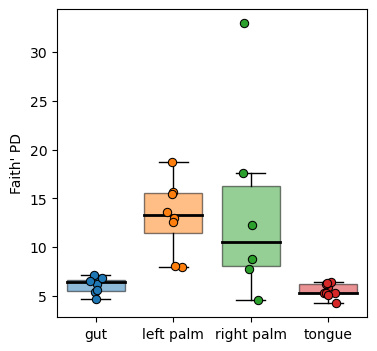

In [42]:
plt.figure(figsize=(4, 4))
for i, (group, datum) in enumerate(grouped.items()):
    bp = plt.boxplot(datum, widths=0.75, positions=(i,), labels=(group,),
                     medianprops=dict(color='k', linewidth=2),
                     showfliers=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set(facecolor=cmap(i), alpha=0.5)
    plt.scatter(np.random.normal(i, 0.05, len(datum)), datum,
                color=cmap(i), edgecolor='k', linewidth=0.75, zorder=2.5)
plt.ylabel('Faith\' PD');

Kruskal-Wallis _H_ test

In [43]:
kruskal(*grouped)

KruskalResult(statistic=18.396001344086017, pvalue=0.00036440958833366775)

Therefore, the differential phylogenetic diversity among body sites is significant.

Given that we know there is **overall** difference among the four body sites, we now want to perform a [post hoc analysis](https://en.wikipedia.org/wiki/Post_hoc_analysis) to assess which **pairs** of groups have significant difference.

This can be done by performing the Kruskal-Wallis _H_ test between every pair of groups, then performing the [Benjamini-Hochberg](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini.E2.80.93Hochberg_procedure) (BH) [FDR correction](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) to adjust the _p_-values, as is done in QIIME 2.

Perform _H_ test on every pair of groups through nested iterations.

In [44]:
res = []
n = grouped.shape[0]
for i in range(n):
    for j in range(i + 1, n):
        test = kruskal(grouped.iloc[i], grouped.iloc[j])
        res.append([grouped.index[i], grouped.index[j],
                    test.statistic, test.pvalue])
res = pd.DataFrame(res, columns=['group_1', 'group_2', 'statistic', 'pvalue'])
res

,group_1,group_2,statistic,pvalue
0,gut,left palm,11.294118,0.000778
1,gut,right palm,4.266667,0.038867
2,gut,tongue,3.000000,0.083265
3,left palm,right palm,0.416667,0.518605
4,left palm,tongue,12.000000,0.000532
5,right palm,tongue,5.013889,0.025145


Perform FDR correction.

In [45]:
from statsmodels.stats.multitest import fdrcorrection

In [46]:
res['qvalue'] = fdrcorrection(res['pvalue'])[1]
res

,group_1,group_2,statistic,pvalue,qvalue
0,gut,left palm,11.294118,0.000778,0.002333
1,gut,right palm,4.266667,0.038867,0.058301
2,gut,tongue,3.000000,0.083265,0.099917
3,left palm,right palm,0.416667,0.518605,0.518605
4,left palm,tongue,12.000000,0.000532,0.002333
5,right palm,tongue,5.013889,0.025145,0.050290


The _q_-values (a.k.a., FDR, or adjusted _p_-values, or corrected _p_-values) are what one should base the conclusion on. The common significance level _q_ <= 0.05 applies.

In [47]:
sigres = res.query('qvalue <= 0.05')
sigres

,group_1,group_2,statistic,pvalue,qvalue
0,gut,left palm,11.294118,0.000778,0.002333
4,left palm,tongue,12.000000,0.000532,0.002333


Note: Another common post hoc analysis for _H_ test is the [Dunn's test](https://www.statology.org/dunns-test/), which is implemented in the Python library [scikit-posthocs](https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn/).

### Correlation analysis

Assess the correlation between Shannon diversity and the experimental time.

In [48]:
meta['elapse'].head()

L1S105    140
L1S140      0
L1S208     84
L1S257    140
L1S281    168
Name: elapse, dtype: int64

Draw a scatter plot to preview the data.

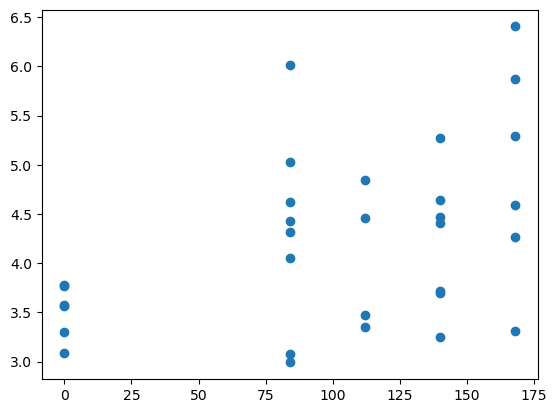

In [49]:
plt.scatter('elapse', 'shannon', data=meta);

Perform linear regression using the [least squares](https://en.wikipedia.org/wiki/Least_squares) method.

In [50]:
from scipy.stats import linregress

In [51]:
reg = linregress(meta['elapse'], meta['shannon'])
reg

LinregressResult(slope=0.006913534847570466, intercept=3.531032427867763, rvalue=0.4445830351645839, pvalue=0.012216854883366336, stderr=0.0025865989469158186, intercept_stderr=0.2986149787388692)

According to the result, the correlation is positive (slope > 0), moderately strong (_r_ = 0.46) and significant (_p_ < 0.01).

Draw the regression line with the scatter plot.

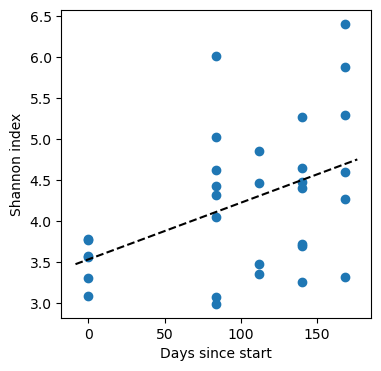

In [52]:
plt.figure(figsize=(4, 4))
plt.scatter('elapse', 'shannon', data=meta)
plt.plot(plt.xlim(), [x * reg.slope + reg.intercept for x in plt.xlim()], 'k--')
plt.xlabel('Days since start')
plt.ylabel('Shannon index');

There are two common metrics to evaluate the correlation coefficient between two variables: [Pearson's _r_](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (parametric) and [Spearman's _ρ_](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) (non-parametric).

As discussed above, because microbiome data are usually highly skewed, Spearman correlation is usually favored over Pearson correlation, unless one can show that both variables fit normal distributions.

In [53]:
from scipy.stats import pearsonr, spearmanr

**Pearson** correlation coefficient (Pearson's _r_) (It is identical to the _r_ in the linear regression result.)

In [54]:
pearsonr(meta['elapse'], meta['shannon'])

(0.444583035164584, 0.012216854883366303)

**Spearman's** rank correlation coefficient (Spearman's _ρ_)

In [55]:
spearmanr(meta['elapse'], meta['shannon'])

SpearmanrResult(correlation=0.40237154473308473, pvalue=0.024828925017091656)

A more comprehensive way to perform regression analysis (as well as other statistical tests) is to use the Python library [statsmodels](https://www.statsmodels.org/stable/index.html) (but the results are identical).

In [56]:
import statsmodels.formula.api as smf

In [57]:
reg = smf.ols('shannon ~ elapse', data=meta).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                shannon   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     7.144
Date:                Sat, 19 Nov 2022   Prob (F-statistic):             0.0122
Time:                        12:22:46   Log-Likelihood:                -36.965
No. Observations:                  31   AIC:                             77.93
Df Residuals:                      29   BIC:                             80.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5310      0.299     11.825      0.000       2.920       4.142
elapse         0.0069      0.003      2.673      0.012       0.002       0.012
==============================================================================
Omnibus:                        1.001   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.705
Skew:                           0.364   Prob(JB):                        0.703
Kurtosis:                       2.870   Cond. No.                         233.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With this regression model, one can plot the 95% confidence interval.

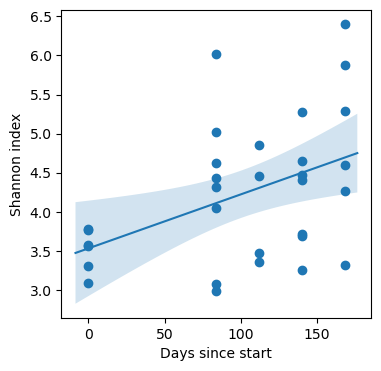

In [58]:
plt.figure(figsize=(4, 4))
plt.scatter('elapse', 'shannon', data=meta, color=cmap(0))
xrange = np.linspace(*plt.xlim(), 50)
pred = reg.get_prediction(pd.Series(xrange, name='elapse'))
plt.plot(xrange, pred.predicted_mean, color=cmap(0))
plt.fill_between(xrange, *zip(*pred.conf_int()),
                 color=cmap(0), alpha=0.2, ec='none')
plt.xlabel('Days since start')
plt.ylabel('Shannon index');

This type of plot can also be achieved using seaborn's `regplot` function.

## Rarefaction curves

A rarefaction curve is to plot the estimate of a metric at different sampling depths, so as to assess 1) how stable this metric is across sampling depths, 2) whether the original sampling effort is sufficient to approximate the true value of the metric.

This is because: a community may have many organisms, but our sampling effort (i.e., DNA sequencing) may only capture a proportion of them. Can we observe all species (or other metrics) among these sampled organisms? This is a question. The more samples we obtain, the more likely we will approach the true number of species in the community (or other metrics).

### Pattern of curves

To make things easier, let's downsample the data table to just 10 samples (5 per subject).

In [59]:
ids_1 = np.random.choice(meta.query('subject == "subject-1"').index, 5, replace=False)
ids_2 = np.random.choice(meta.query('subject == "subject-2"').index, 5, replace=False)
ids = list(ids_1) + list(ids_2)
print(ids)

['L5S203', 'L2S155', 'L2S222', 'L3S294', 'L1S105', 'L4S112', 'L1S208', 'L4S63', 'L2S382', 'L5S240']


In [60]:
data_n8 = data[ids]
data_n8 = data_n8.loc[data_n8.sum(axis=1) > 0]
data_n8.head()

,L5S203,L2S155,L2S222,L3S294,L1S105,L4S112,L1S208,L4S63,L2S382,L5S240
#OTU ID,,,,,,,,,,
4b5eeb300368260019c1fbc7a3c718fc,0,10,0,0,2175,55,0,0,0,0
fe30ff0f71a38a39cf1717ec2be3a2fc,0,0,32,0,5,330,0,160,80,374
d29fe3c70564fc0f69f2c03e0d1e5561,215,353,104,46,0,1269,0,417,494,117
868528ca947bc57b69ffdf83e6b73bae,5,0,0,0,0,0,2107,0,0,10
154709e160e8cada6bfb21115acc80f5,0,0,0,0,803,0,694,0,0,0


Define a series of sampling depths.

In [61]:
depths = list(range(0, 4500, 500))
depths

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

Perform random sampling at each depth.

In [62]:
# when depth = 0, diversity = 0
sobs_rc = [pd.Series(0, index=ids)]

# start from 2nd depth
for n in depths[1:]:

    # drop samples below current depth
    data_ = data_n8.loc[:, data_n8.sum() >= n]

    # perform random subsampling
    data_sub_ = data_.apply(subsample_counts, args=(n,))

    # calculate observed features
    sobs_ = (data_sub_ > 0).sum()
    
    # append to results
    sobs_rc.append(sobs_)

In [63]:
sobs_rc[5].head()

L2S155    108
L2S222    141
L1S105     62
L4S112    151
L1S208     82
dtype: int64

Plot the rarefaction curves.

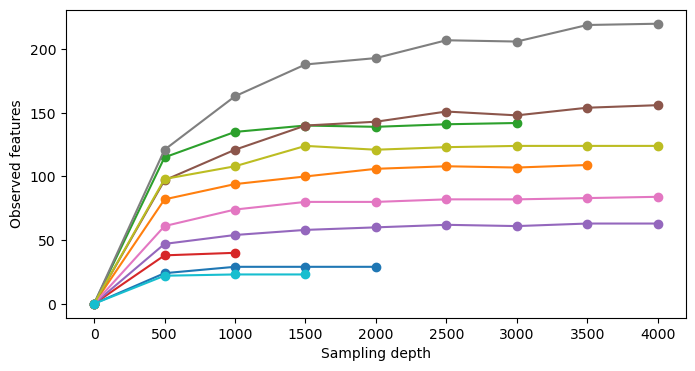

In [64]:
plt.figure(figsize=(8, 4))
for id_ in ids:
    sobs_ = [x.get(id_) for x in sobs_rc]
    plt.plot(depths, sobs_, marker='o')
plt.xlabel('Sampling depth')
plt.ylabel('Observed features');

As we can see, the observed feature number decreases as the sampling depth decreases. However, in the majority width (about 1000 to 4000) of the figure, most samples have (almost) reached a plateau (asymptote). Therefore we can predict that, even if we continue to increase sampling depth (which is not feasible because we only have this much sequencing data), we won't expect to observe a notable increase of observed features. Therefore, we can confidently say that the current sampling effort is sufficient to estimate the true feature number of most samples.

### Technical replicates

To make this process more robust, one should perform multiple replicates per sampling depth.

In [65]:
reps = 10

In [66]:
sobs_rc = [pd.DataFrame(0, index=range(reps), columns=ids)]
for n in depths[1:]:
    res_ = []
    data_ = data_n8.loc[:, data_n8.sum() >= n]
    for i in range(reps):
        data_sub_ = data_.apply(subsample_counts, args=(n,))
        sobs_ = (data_sub_ > 0).sum()
        res_.append(sobs_)
    sobs_rc.append(pd.DataFrame(res_))

In [67]:
sobs_rc[5].head()

,L2S155,L2S222,L1S105,L4S112,L1S208,L4S63,L2S382
0,108,142,63,144,82,205,124
1,108,142,61,146,82,208,124
2,108,141,63,146,82,204,121
3,109,141,61,153,82,213,124
4,107,141,62,147,83,203,123


And plot each sample / depth combination as a boxplot.

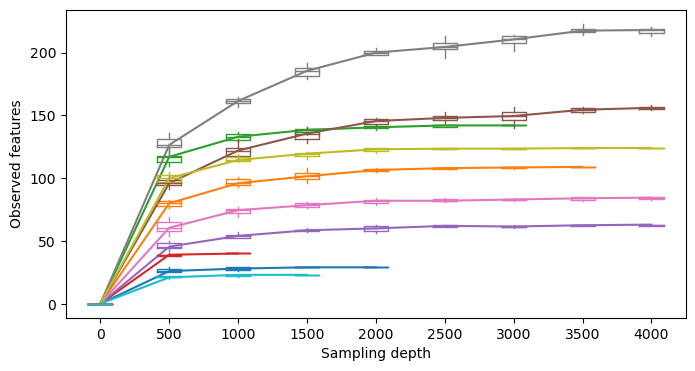

In [68]:
plt.figure(figsize=(8, 4))
for i, id_ in enumerate(ids):
    color = cmap(i)
    sobs_ = [x.get(id_) for x in sobs_rc]
    datum = pd.concat(sobs_, axis=1)
    plt.boxplot(datum, widths=0.35,
                boxprops=dict(color=color),
                whiskerprops=dict(color=color),
                medianprops=dict(color=color),
                showfliers=False, showcaps=False)
    plt.plot(np.arange(datum.shape[1]) + 1,
             datum.median().values, color=color)
plt.xticks(np.arange(len(depths)) + 1, depths)
plt.xlabel('Sampling depth')
plt.ylabel('Observed features');

Now, we will generalize this to multiple alpha diversity metrics.

In [69]:
metrics = ('sobs', 'shannon', 'faith_pd')
names = ('Observed features', 'Shannon index', 'Faith\'s PD')

In [70]:
adiv_rc = {x: [pd.DataFrame(0, index=range(reps), columns=ids)]
           for x in metrics}
for n in depths[1:]:
    res_ = {x: [] for x in metrics}
    data_ = data_n8.loc[:, data_n8.sum() >= n]
    for i in range(reps):
        data_sub_ = data_.apply(subsample_counts, args=(n,))
        data_sub_t_ = data_sub_.T
        counts_, ids_ = data_sub_t_.values, data_sub_t_.index
        res_['sobs'].append(alpha_diversity('observed_otus', counts_, ids_))
        res_['shannon'].append(alpha_diversity('shannon', counts_, ids_))
        res_['faith_pd'].append(alpha_diversity(
            'faith_pd', counts_, ids_, otu_ids=data_sub_t_.columns, tree=tree))
    for m in metrics:
        adiv_rc[m].append(pd.DataFrame(res_[m]))

In [71]:
adiv_rc['faith_pd'][5].head()

,L2S155,L2S222,L1S105,L4S112,L1S208,L4S63,L2S382
0,17.974494,25.633105,6.594195,20.707438,8.172470,30.954109,13.592461
1,17.931523,25.633105,6.473668,24.839925,7.076347,34.936170,13.561433
2,17.792981,25.564623,6.990402,20.579406,8.179140,28.649147,13.592461
3,17.038767,25.633105,6.582617,20.418383,7.261930,30.241606,13.592461
4,17.931523,25.633105,6.688727,21.607047,7.806077,34.657108,13.330720


Generate plots for all metrics and compare.

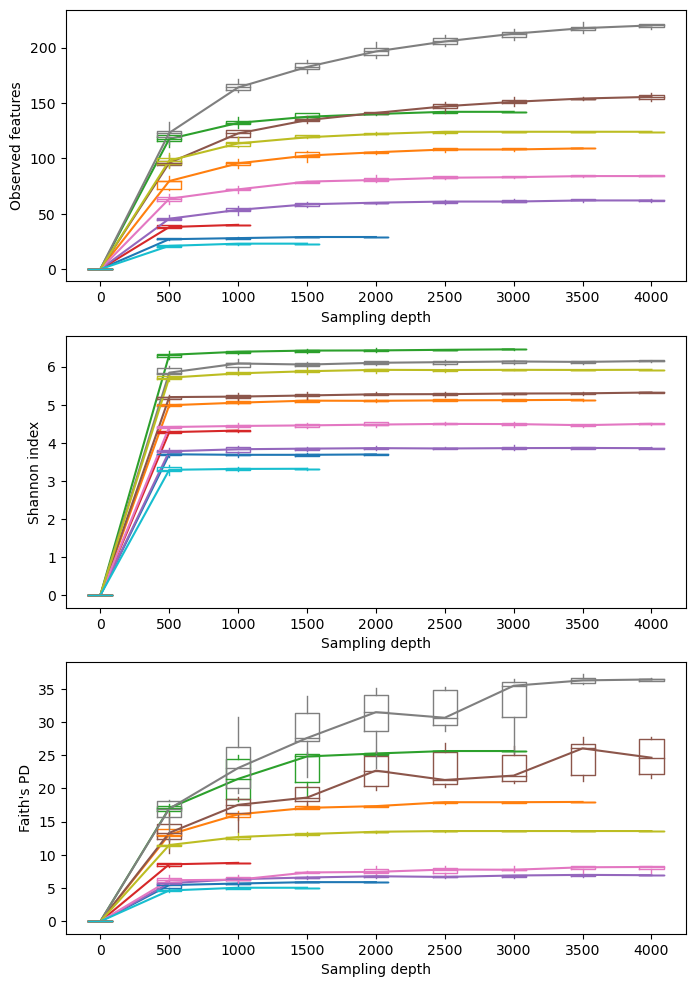

In [72]:
plt.figure(figsize=(8, 12))
for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)
    for j, id_ in enumerate(ids):
        color = cmap(j)
        sobs_ = [x.get(id_) for x in adiv_rc[metric]]
        datum = pd.concat(sobs_, axis=1)
        plt.boxplot(datum, widths=0.35,
                    boxprops=dict(color=color),
                    whiskerprops=dict(color=color),
                    medianprops=dict(color=color),
                    showfliers=False, showcaps=False)
        plt.plot(np.arange(datum.shape[1]) + 1,
                 datum.median().values, color=color)
    plt.xticks(np.arange(len(depths)) + 1, depths)
    plt.xlabel('Sampling depth')
    plt.ylabel(names[i]);

By observing the patterns, we notice that Shannon index is the most stable metric. This is largely because it considers feature **abundance**. Faith's PD however is quite unstable with certain samples, likely because these samples are heavily influenced by some rare species with deep branches in the phylogenetic tree (my guess; no examination). This observation is consistent with QIIME 2's official [result](https://view.qiime2.org/?src=https%3A%2F%2Fdocs.qiime2.org%2F2022.8%2Fdata%2Ftutorials%2Fmoving-pictures%2Falpha-rarefaction.qzv).

### Biological results

Beyond evaluating the changes in the alpha diversity metrics, it is probably more important to assess the **stability** of estimates of biologically relevant values. A good metric should produce stable results across a reasonable range of sampling depths.

Specify a smaller gradient of sampling depths (because some samples will be lost at higher sampling depths).

In [73]:
depths = list(range(0, 2250, 250))
depths

[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

The following analysis calculates Faith's PD at each sampling depth using the entire dataset (not the _n_ = 8 subset).

In [74]:
ids = data.columns.tolist()
faith_pds = [pd.DataFrame(0, index=range(reps), columns=ids)]
for n in depths[1:]:
    res_ = []
    data_ = data.loc[:, data.sum() >= n]
    for i in range(reps):
        data_sub_ = data_.apply(subsample_counts, args=(n,))
        data_sub_t_ = data_sub_.T
        counts_, ids_ = data_sub_t_.values, data_sub_t_.index
        res_.append(alpha_diversity(
            'faith_pd', counts_, ids_, otu_ids=data_sub_t_.columns, tree=tree))
    faith_pds.append(pd.DataFrame(res_))

Group samples by subject.

In [75]:
faith_pds = [x.groupby(meta['subject'], axis=1).apply(np.array) for x in faith_pds]

In [76]:
faith_pds[5]

subject
subject-1    [[6.464741124, 5.638528003, 5.782145585, 4.417...
subject-2    [[6.502452669, 6.708830829, 7.254032361, 6.292...
dtype: object

Calculate group mean per replicate per depth.

In [77]:
faith_pds_mean = [x.apply(np.mean, axis=1) for x in faith_pds]

In [78]:
faith_pds_mean[5]

subject
subject-1    [9.114586586538461, 9.13976545023077, 9.194626...
subject-2    [10.426912090666667, 10.164747132733332, 10.37...
dtype: object

Plot the distribution of means of each group.

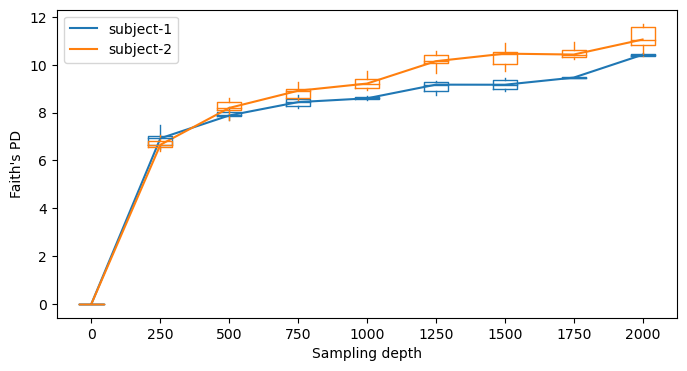

In [79]:
plt.figure(figsize=(8, 4))
for i in range(2):
    group = f'subject-{i + 1}'
    color = cmap(i)
    datum = np.vstack([x.loc[group] for x in faith_pds_mean])
    plt.boxplot(datum.T, widths=0.35,
                boxprops=dict(color=color),
                whiskerprops=dict(color=color),
                medianprops=dict(color=color),
                showfliers=False, showcaps=False)
    plt.plot(np.arange(datum.shape[0]) + 1, np.median(
        datum, axis=1), color=color, label=group)
plt.legend()
plt.xticks(np.arange(len(depths)) + 1, depths)
plt.xlabel('Sampling depth')
plt.ylabel('Faith\'s PD');

Perform Kruskal-Wallis _H_ test on the two groups per replicate per depth.

In [80]:
faith_pds_kw = [[tuple(kruskal(*y)) for y in zip(*x)] for x in faith_pds[1:]]

In [81]:
faith_pds_kw[5]

[(3.0518053375196104, 0.08064744976426026),
 (1.5918367346938709, 0.20706391185528422),
 (2.262951334379906, 0.13250132948726256),
 (2.4113029827315557, 0.12046206278114116),
 (2.5643642072213453, 0.10929649096336327),
 (2.262951334379906, 0.13250132948726256),
 (2.722135007849289, 0.09896556064435104),
 (2.4113029827315557, 0.12046206278114116),
 (2.262951334379906, 0.13250132948726256),
 (2.262951334379906, 0.13250132948726256)]

Plot _H_ statistics (which evaluate the differences between means).

In [82]:
stats = [[y[0] for y in x] for x in faith_pds_kw]

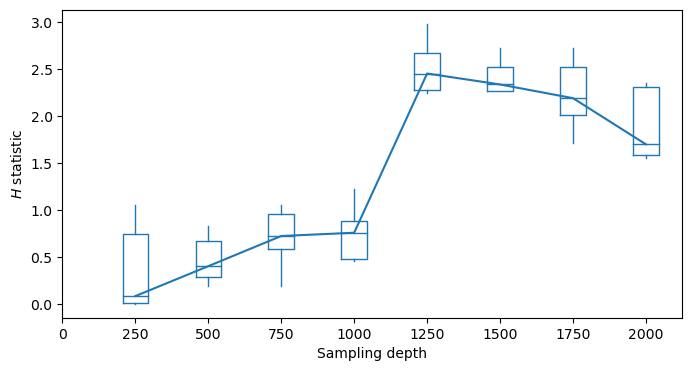

In [83]:
plt.figure(figsize=(8, 4))
color = cmap(0)
plt.boxplot(stats, widths=0.35,
            boxprops=dict(color=color),
            whiskerprops=dict(color=color),
            medianprops=dict(color=color),
            showfliers=False, showcaps=False)
plt.plot(np.arange(len(stats)) + 1, np.median(
    stats, axis=1), color=color)
plt.xticks(np.arange(len(depths)), depths)
plt.xlabel('Sampling depth')
plt.ylabel('$\it{H}$ statistic');

Plot _p_-values (significance of differences) in log scale.

In [84]:
pvals = [[y[1] for y in x] for x in faith_pds_kw]

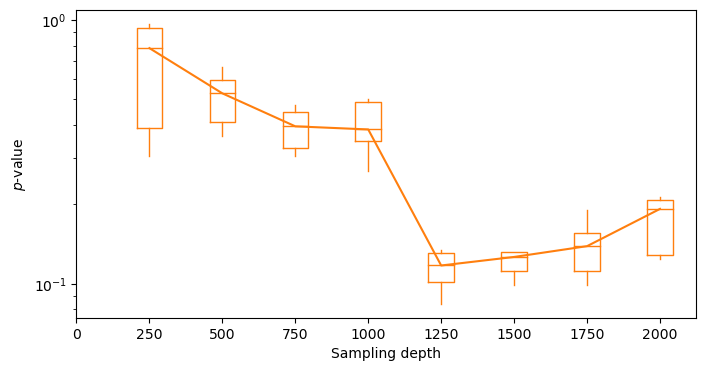

In [85]:
plt.figure(figsize=(8, 4))
color = cmap(1)
plt.boxplot(pvals, widths=0.35,
            boxprops=dict(color=color),
            whiskerprops=dict(color=color),
            medianprops=dict(color=color),
            showfliers=False, showcaps=False)
plt.plot(np.arange(len(pvals)) + 1, np.median(
    pvals, axis=1), color=color)
plt.yscale('log')
plt.xticks(np.arange(len(depths)), depths)
plt.xlabel('Sampling depth')
plt.ylabel('$\it{p}$-value');

The plots show that the estimated biological results are not stable across sampling depths (and even across replicates). Therefore, Faith's PD is not an ideal metric for microbiome research. There is room for improvement.